### Creating a dashboard to visualize clustering of cohorts into topics/themes based on the probability of key words being used together. Not removing any duplicates to emphasize the quantity of posts against a particular topic through the bubble size.

In [1]:
import pandas as pd
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

In [2]:


# Select relevant columns for analysis if those values where df['CohortCat'] = ['cohort']
data = df[['Cohort', 'CohortCat']]
data = data[data['CohortCat'] == 'cohort']

# remove the 'cohortcat' column
data = data.drop('CohortCat', axis=1)

# if the 'cohort' value in column is only used once, remove that row
data = data.groupby('Cohort').filter(lambda x: len(x) > 1)

# Clean and preprocess the text data
def preprocess_text(text):
    processed_text = []
    for token in simple_preprocess(str(text)):  # Convert to string
        if token not in STOPWORDS and len(token) > 3:
            processed_text.append(token)
    return processed_text

data['Cleaned Text'] = data['Cohort'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(data['Cleaned Text'])

# Convert the documents to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in data['Cleaned Text']]

# Train the LDA model (25,50)
num_topics = 25  # Set the desired number of topics
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50)

# Prepare the data for visualization using pyLDAvis
vis_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

# Create the interactive visualization
pyLDAvis.display(vis_data)


## Broad Overview: There are 3 dimensions along which all our content is produced (version of visualization keeps refreshing/changes in axis)
1. Top right is very related to parents, kids, girls, boys and the other key words are more contextual to their need/activity/priority
2. Bottom right i think is not very consistent - multiple themes found within each bubble. One prominent theme i believe is women - with huge focus on menstruation and comfort
3. Intersection of both above has topics that are moving to activities to milennials/zillenials but also over reaching topics related to parents as shown. These activities are common across both types of audience groups - ranging to cars, luxury, travel, fitness and shopping
4. Top left has two promient themes - systems/gov/municipalities and fan/sports/coach/seasons

This gives us a general sense of our distribution of content on our posts via cohorts. However, intuiteively we should be able to get something very straight forward. With age groups on different quadrant, overlapping activities on the axis, and specific activities in the centre of each quadrant - ASSUMING OUR IDEAL WAY OF TARGETTING CUSTOMERS FOR MAXIMUM COST EFFICIENCY. 

That is not the case unfortunately. These could be because of few reasons:
1. Mis-distribution of cohorts - we genuinely only focus on these topics prominently and are actively not engaging in other age groups or activities
2. Mis-categorization of cohorts - we are creating content and seeing the results but it has not been correctly categorized to the right cohort
3. Un-standardized practise of cohort nomenclature - we are not using the right keywords to create cohorts, that is not allowing us to see the specificites of what we are targeting

In [ ]:
# Count of unique values of cohort
data['Cohort'].nunique()

416

In [4]:
df.columns

Index(['Cohort', 'CohortCat', 'Creative', 'Client', 'Day On', 'Platform',
       'Post Date', 'Post ID', 'Comments', 'Comments - Max', 'Engagement Rate',
       'Engagements - Max', 'Impressions', 'Impressions - Max',
       'Latest MER - Step 2', 'Max of MER - Step 3',
       'Most Recent MER Date - Step 1', 'Nr. of Creatives - Post Date',
       'Nr. of Creatives MAX', 'Reactions', 'Replies', 'Retweets', 'Saves',
       'Shares', 'V Lift - Max', 'VaynerLift'],
      dtype='object')

## Filtering the dashboard on a client level

In [5]:
import pandas as pd
import gensim
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'Client', 'VaynerLift']]
data = data[data['CohortCat'] == 'cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Clean and preprocess the text data
def preprocess_text(text):
    processed_text = []
    for token in simple_preprocess(str(text)):
        if token not in STOPWORDS and len(token) > 3:
            processed_text.append(token)
    return processed_text

data['Cleaned Text'] = data['Cohort'].apply(preprocess_text)

# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(data['Cleaned Text'])

# Convert the documents to a bag-of-words representation
bow_corpus = [dictionary.doc2bow(doc) for doc in data['Cleaned Text']]

# Train the LDA model
num_topics = 15
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=50)

# Prepare the data for visualization using pyLDAvis
vis_data = gensimvis.prepare(lda_model, bow_corpus, dictionary)

# Calculate cumulative Vayner Lift score for each topic
topic_vayner_lift = {}
for i, topic in enumerate(lda_model.show_topics(num_topics=num_topics, formatted=False)):
    topic_vayner_lift[i] = df.loc[df['Cohort'].isin(data['Cohort'])]['VaynerLift'].mean()

# Add cumulative Vayner Lift score to visualization data
vis_data.topic_info['VaynerLift'] = vis_data.topic_info['Category'].map(topic_vayner_lift)

# Define a function to update the visualization based on the selected client
def update_visualization(selected_client):
    # Filter the data based on the selected client
    filtered_data = data[data['Client'] == selected_client]

    # Create a dictionary representation of the filtered documents
    filtered_dictionary = gensim.corpora.Dictionary(filtered_data['Cleaned Text'])

    # Convert the filtered documents to a bag-of-words representation
    filtered_bow_corpus = [filtered_dictionary.doc2bow(doc) for doc in filtered_data['Cleaned Text']]

    # Train the LDA model on the filtered data
    filtered_lda_model = gensim.models.LdaModel(filtered_bow_corpus, num_topics=num_topics, id2word=filtered_dictionary, passes=30)

    # Prepare the filtered data for visualization using pyLDAvis
    filtered_vis_data = gensimvis.prepare(filtered_lda_model, filtered_bow_corpus, filtered_dictionary)

    # Calculate cumulative Vayner Lift score for each topic on the filtered data
    filtered_topic_vayner_lift = {}
    for i, topic in enumerate(filtered_lda_model.show_topics(num_topics=num_topics, formatted=False)):
        filtered_topic_vayner_lift[i] = filtered_data['VaynerLift'].mean()

    # Add cumulative Vayner Lift score to filtered visualization data
    filtered_vis_data.topic_info['VaynerLift'] = filtered_vis_data.topic_info['Category'].map(filtered_topic_vayner_lift)

    # Create the updated interactive visualization
    pyLDAvis.display(filtered_vis_data)

# Get the unique values from the 'Client' column
clients = data['Client'].unique()

# Prompt the user for the client filter
print("Available Clients:")
for i, client in enumerate(clients):
    print(f"{i+1}. {client}")

client_selection = input("Select a Client (enter the corresponding number): ")
selected_client = clients[int(client_selection) - 1]

# Update the visualization based on the selected client
update_visualization(selected_client)


Available Clients:
1. Fanatics
2. EchoPark
3. Ford
4. Casper
5. Wegmans
6. Durex
7. Pico
8. Kimberly Clark
9. Wander Wheels
10. Diageo
11. Zappos
12. Coach
13. St Jude
14. Pearson
15. Ford Pro
16. NatWest


In [6]:
# Define a function to update the visualization based on the selected client
def update_visualization(client):
    print("Selected Client:", client)

    # Filter the data based on the selected client
    filtered_data = data[data['Client'] == client]
    print("Filtered Data:")
    print(filtered_data.head())

    # Create a dictionary representation of the filtered documents
    filtered_dictionary = gensim.corpora.Dictionary(filtered_data['Cleaned Text'])
    print("Filtered Dictionary:")
    print(filtered_dictionary)

    # Convert the filtered documents to a bag-of-words representation
    filtered_bow_corpus = [filtered_dictionary.doc2bow(doc) for doc in filtered_data['Cleaned Text']]
    print("Filtered BOW Corpus:")
    print(filtered_bow_corpus[:5])

    # Train the LDA model on the filtered data
    filtered_lda_model = gensim.models.LdaModel(filtered_bow_corpus, num_topics=num_topics, id2word=filtered_dictionary, passes=30)
    print("Filtered LDA Model:")
    print(filtered_lda_model)

    # Prepare the filtered data for visualization using pyLDAvis
    filtered_vis_data = gensimvis.prepare(filtered_lda_model, filtered_bow_corpus, filtered_dictionary)
    print("Filtered Visualization Data:")
    print(filtered_vis_data)

    # Save the interactive visualization as an HTML file
    pyLDAvis.save_html(filtered_vis_data, 'lda_visualization.html')

    # Display a message to indicate the file name and location
    print("Interactive visualization saved as 'lda_visualization.html'")

    # Open the HTML file in the default web browser
    import webbrowser
    webbrowser.open('lda_visualization.html')

# Get the unique values from the 'Client' column
clients = data['Client'].unique()
print("Available Clients:")
for i, client in enumerate(clients):
    print(f"{i+1}. {client}")

client_selection = input("Select a Client (enter the corresponding number): ")
selected_client = clients[int(client_selection) - 1]

# Update the visualization based on the selected client
update_visualization(selected_client)


Available Clients:
1. Fanatics
2. EchoPark
3. Ford
4. Casper
5. Wegmans
6. Durex
7. Pico
8. Kimberly Clark
9. Wander Wheels
10. Diageo
11. Zappos
12. Coach
13. St Jude
14. Pearson
15. Ford Pro
16. NatWest
Selected Client: Fanatics
Filtered Data:
                                               Cohort    Client  VaynerLift  \
0   30-SOMETHING LEBRON FANS SAVORING HIS FINAL SE...  Fanatics    0.257534   
34  Gameday Diners Treating The Stadium As An Elev...  Fanatics    0.606053   
40  Young Kiss Cam Hopefuls Taking Matches Out To ...  Fanatics    0.512694   
68  Spotify Playlist Curators Tracking Bullpen Ent...  Fanatics    0.055691   
69  CAUTIOUSLY OPTIMISTIC PARENTS PASSING DOWN THE...  Fanatics    0.124052   

                                         Cleaned Text  
0            [lebron, fans, savoring, final, seasons]  
34  [gameday, diners, treating, stadium, elevated,...  
40  [young, kiss, hopefuls, taking, matches, ballg...  
68  [spotify, playlist, curators, tracking, bullpe...  

Assuming the first two reasons for an unstable graph aren't correct, we can prove if there is an issue with the number of keywords/specifity being used when tackling a cohort. This brings us to our question on the value of 'cohorts with teeth' and how the lack of it might or might not impact the performance

To analyze that, we assume = more the keywords in a cohort, more the specificity and we are creating content structurally that is targetting audience groups with the set intention. For eg. Assuming a random high number of keywords - 20, we see below that there is 6% decrease already with cohorts that had lesser keywords. 

In [7]:
# Save the interactive visualization as an HTML file
pyLDAvis.save_html(vis_data, 'lda_visualization.html')

# Display a message to indicate the file name and location
print("Interactive visualization saved as 'lda_visualization.html'")

# Open the HTML file in the default web browser
import os
import webbrowser

# Get the full path of the saved HTML file
html_file_path = os.path.abspath('lda_visualization.html')

# Open the HTML file in the default web browser
webbrowser.open('file://' + html_file_path)


Interactive visualization saved as 'lda_visualization.html'


True

## Analyzing cohorts with teeth

In [8]:
import pandas as pd

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Count the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)
#data.drop_duplicates(subset='Cohort', inplace=True)

# Calculate the average Vayner Lift for cohorts with at least four keywords
avg_vayner_lift_at_least_4_keywords = data[data['KeywordCount'] >= 20]['VaynerLift'].mean()

# Calculate the average Vayner Lift for cohorts with less than four keywords
avg_vayner_lift_less_than_4_keywords = data[data['KeywordCount'] < 20]['VaynerLift'].mean()

# Print the average Vayner Lift for cohorts with at least four keywords and less than four keywords
print("Average Vayner Lift for cohorts with at least four keywords:", avg_vayner_lift_at_least_4_keywords)
print("Average Vayner Lift for cohorts with less than four keywords:", avg_vayner_lift_less_than_4_keywords)


Average Vayner Lift for cohorts with at least four keywords: 0.3372968286829268
Average Vayner Lift for cohorts with less than four keywords: 0.2731628340213649


Specifically, these were the cohorts that led to this higher number. Although they don't completely align with the teeth, it still does provide a lot of context to the cohort. 

In [9]:
cohorts_with_at_least_20_keywords = data[data['KeywordCount'] >= 20]['Cohort'].unique()

# Print the cohorts with at least 20 keywords
for cohort in cohorts_with_at_least_20_keywords:
    print(cohort)

UBK - Menstruators who are living a very active lifestyle and need a pad that is secure & won’t leak.
UBK - Menstruators who almost exclusively wear pads (from UbK or competitors) and favor their comfort and feel over tampons.
New Military Parents of Virginia Who Want to Spend As Much Time with Their Child As Possible During K-12 to Make Up For Complex Schedule


In [10]:
# Filter cohorts with at least 20 keywords
cohorts_with_at_least_20_keywords = data[data['KeywordCount'] >= 20]['Cohort']

# Print the count of cohorts with at least 20 keywords
count_of_cohorts_with_at_least_20_keywords = len(cohorts_with_at_least_20_keywords)
print("Count of posts with at least 20 keywords:", count_of_cohorts_with_at_least_20_keywords)


Count of posts with at least 20 keywords: 41


We had only 41 posts/10K approx rows with these many keywords - which highlights a huge mis-proportion of volume of posts that are catered to cohorts with teeth. On further analysis, we should look at the average vayner lift for every length of keyword in a cohort to see if this is a trend of mis-proportion of cohorts w/o teeth, and do cohorts with teeth indeed have a higher performance. 

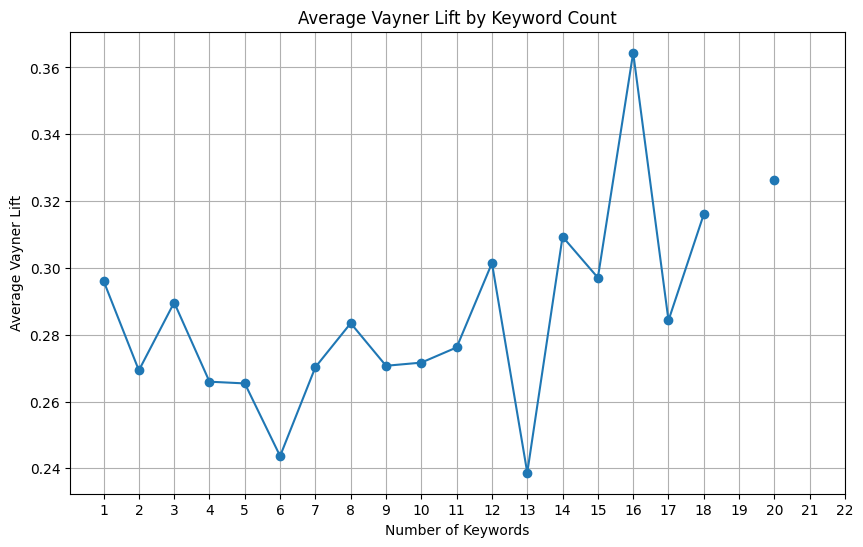

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Calculate the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)

# Calculate the average Vayner Lift score for cohorts of each keyword length
avg_vayner_lift_by_keyword_count = {}
for keyword_count in range(1, 23):
    avg_vayner_lift = data[data['KeywordCount'] == keyword_count]['VaynerLift'].mean()
    avg_vayner_lift_by_keyword_count[keyword_count] = avg_vayner_lift

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o')
plt.xlabel('Number of Keywords')
plt.ylabel('Average Vayner Lift')
plt.title('Average Vayner Lift by Keyword Count')
plt.xticks(range(1, 23))
plt.grid(True)
plt.show()


## Average vayner lift mean seems to have an upward trend with higher keywords with some inconsistencies. This could be again because of two reasons:
1. There is indeed no pattern
2. Mis-distribution of volume of posts
3. Performance for those specific cohorts specifically didn't resonate, and hence it was affected due to external reasons

Assuming, there is a pattern, let's look at what's happening for the highest vayner lift keyword cohorts - 16. These are indeed cohorts with teeth - reflecting on generation, activity - not location specific

In [12]:
cohorts_with_at_least_16_keywords = data[data['KeywordCount'] == 16]['Cohort'].unique()

# Print the cohorts with at least 20 keywords
for cohort in cohorts_with_at_least_16_keywords:
    print(cohort)

Millennials Who Remember Coach From Their Childhoods But Don’t Remember Why It Went Out Of Style
UBK - Menstruators who are returning to their cycles again after time away. (IUDS, BC, Post-Partum)
SCOTT - Gen Z'ers Who Just Left the Nest and Realized TP Isn't Always Just There
Wealthy Football Fans Looking Who Donate Because They Feel Money Is Their Ticket to Doing Good


In [13]:
# Print the count of cohorts with at least 16 keywords
count_of_cohorts_with_16_keywords = len(cohorts_with_at_least_16_keywords)
print("Count of posts with at least 16 keywords:", count_of_cohorts_with_16_keywords)

Count of posts with at least 16 keywords: 4


Let's also look at the volume of posts to see if there is a bias on the dips!

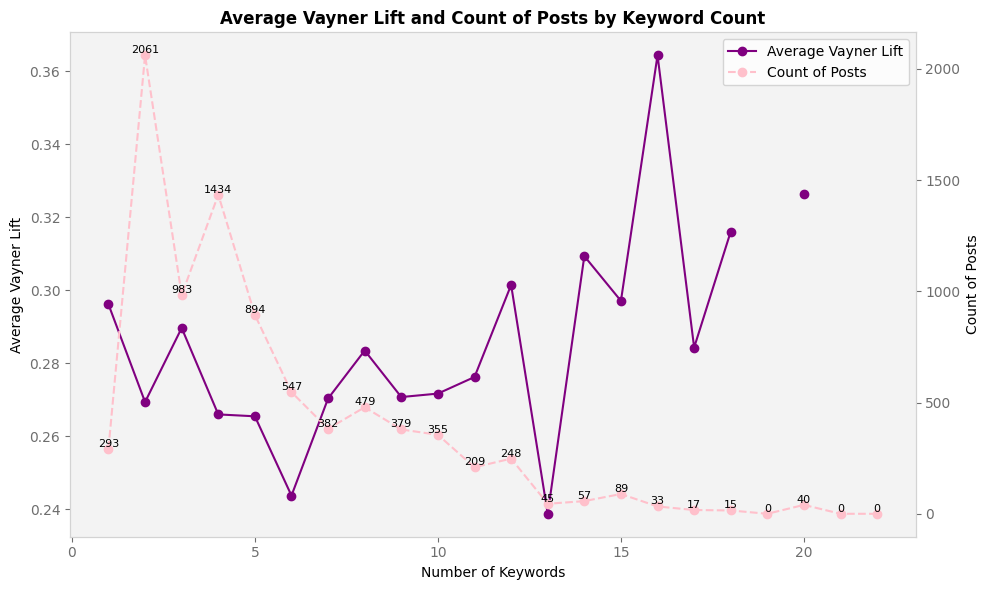

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Calculate the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)

# Calculate the average Vayner Lift score and count of cohorts for each keyword length
avg_vayner_lift_by_keyword_count = {}
count_of_cohorts_by_keyword_count = {}
for keyword_count in range(1, 23):
    avg_vayner_lift = data[data['KeywordCount'] == keyword_count]['VaynerLift'].mean()
    count_of_cohorts = data[data['KeywordCount'] == keyword_count]['Cohort'].count()
    avg_vayner_lift_by_keyword_count[keyword_count] = avg_vayner_lift
    count_of_cohorts_by_keyword_count[keyword_count] = count_of_cohorts

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o', label='Average Vayner Lift', color='purple')
ax1.set_xlabel('Number of Keywords')
ax1.set_ylabel('Average Vayner Lift')
ax1.set_title('Average Vayner Lift and Count of Posts by Keyword Count', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values(), linestyle='--', color='pink', marker='o', label='Count of Posts')
ax2.set_ylabel('Count of Posts')

# Add labels for count of posts on top of the line graph
for x, y in zip(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values()):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)

# Move the legend to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust the layout and spacing
plt.tight_layout()

# Set pastel shades for the plot
ax1.set_facecolor('#F3F3F3')
ax1.spines['bottom'].set_color('#D3D3D3')
ax1.spines['top'].set_color('#D3D3D3')
ax1.spines['right'].set_color('#D3D3D3')
ax1.spines['left'].set_color('#D3D3D3')
ax1.tick_params(axis='x', colors='#6E6E6E')
ax1.tick_params(axis='y', colors='#6E6E6E')

ax2.spines['bottom'].set_color('#D3D3D3')
ax2.spines['top'].set_color('#D3D3D3')
ax2.spines['right'].set_color('#D3D3D3')
ax2.spines['left'].set_color('#D3D3D3')
ax2.tick_params(axis='y', colors='#6E6E6E')

plt.show()

# Dips for higher keywords - 13 and 17

There indeed is! We are creating almost 20-30% of posts against cohorts with 2-4 keywords, which intuitively wouldn't give alot of content. These comparatively have lesser vayner lift mean - not resonating with our audience as much as we could. 

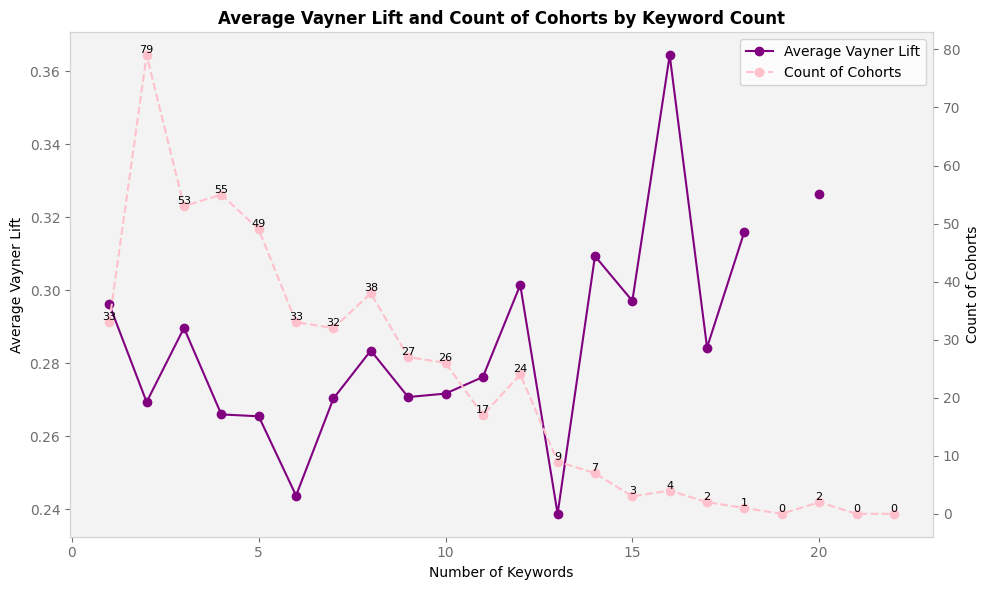

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from a CSV file (replace 'data.csv' with your actual file path)
df = pd.read_csv('/Users/trishitasingh/Downloads/cohortlabels.csv')

# Select relevant columns for analysis if those values where df['CohortCat'] = 'cohort'
data = df[['Cohort', 'CohortCat', 'VaynerLift']]
data = data[data['CohortCat'] == 'cohort']

# Remove the 'CohortCat' column
data = data.drop('CohortCat', axis=1)

# Calculate the number of keywords in each cohort
data['KeywordCount'] = data['Cohort'].str.split().apply(len)

# Calculate the average Vayner Lift score and count of cohorts for each keyword length
avg_vayner_lift_by_keyword_count = {}
count_of_cohorts_by_keyword_count = {}
for keyword_count in range(1, 23):
    avg_vayner_lift = data[data['KeywordCount'] == keyword_count]['VaynerLift'].mean()
    count_of_cohorts = data[data['KeywordCount'] == keyword_count]['Cohort'].nunique()
    avg_vayner_lift_by_keyword_count[keyword_count] = avg_vayner_lift
    count_of_cohorts_by_keyword_count[keyword_count] = count_of_cohorts

# Plot the graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(avg_vayner_lift_by_keyword_count.keys(), avg_vayner_lift_by_keyword_count.values(), marker='o', label='Average Vayner Lift', color='purple')
ax1.set_xlabel('Number of Keywords')
ax1.set_ylabel('Average Vayner Lift')
ax1.set_title('Average Vayner Lift and Count of Cohorts by Keyword Count', fontweight='bold')

ax2 = ax1.twinx()
ax2.plot(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values(), linestyle='--', color='pink', marker='o', label='Count of Cohorts')
ax2.set_ylabel('Count of Cohorts')

# Add labels for count of posts on top of the line graph
for x, y in zip(count_of_cohorts_by_keyword_count.keys(), count_of_cohorts_by_keyword_count.values()):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)

# Move the legend to the top right
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Adjust the layout and spacing
plt.tight_layout()

# Set pastel shades for the plot
ax1.set_facecolor('#F3F3F3')
ax1.spines['bottom'].set_color('#D3D3D3')
ax1.spines['top'].set_color('#D3D3D3')
ax1.spines['right'].set_color('#D3D3D3')
ax1.spines['left'].set_color('#D3D3D3')
ax1.tick_params(axis='x', colors='#6E6E6E')
ax1.tick_params(axis='y', colors='#6E6E6E')

ax2.spines['bottom'].set_color('#D3D3D3')
ax2.spines['top'].set_color('#D3D3D3')
ax2.spines['right'].set_color('#D3D3D3')
ax2.spines['left'].set_color('#D3D3D3')
ax2.tick_params(axis='y', colors='#6E6E6E')

plt.show()

# Dips for higher keywords - 13 and 17


Similarly holds true for unique cohorts. We are creating a huge chunk of cohorts with 2-4 keywords, which intuitively wouldn't give alot of content. Our cohorts for keywords greater than 12 range only between 0-9. This explains the bias of the dips, affirms the mis-distribution of posts, and shows the potential of high-performance from cohorts with teeth for the few cohorts/posts that have launched. 

### Analysis of posts that had dips

In [16]:
# Filter the DataFrame for cohorts with 13 keywords
cohort_13_keywords = df[df['Cohort'].fillna('').str.split().apply(len) == 13]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_13_keywords['Client'].unique()

# Print the 'client' values
for client in clients:
    print(client)


Wegmans
Fanatics
Coach
Pearson


In [17]:
# Filter the DataFrame for cohorts with 13 keywords
cohort_13_keywords = df[df['Cohort'].fillna('').str.split().apply(len) == 13]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_13_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

Last Minute Meal Seekers (Who Believe There’s Not Enough Time To Cook Healthy)
FEMALE GOLFERS WHO HAVE BEEN SNUBBED ON THE GREEN ONE TOO MANY TIMES
FANS OF THE KELCE FAMILY BEFORE THEY BECOME INSUFFERABLE AT THE SUPER BOWL
21-40 YEAR OLD BROS WHO ARE SEDUCED BY THE TIPS IN THE CHAT
History Buffs Who Need To See True Heritage and Lineage In Their Brands
IN Parents of LGBTQ+ Youth Unsettled by the States Lack of Protection Laws
Adventurous Eaters Seeking Cultural Flavors but Too Intimidated to Shop at Ethnic Markets
California Parents of Students Seeking to Study Arts, Audio Visual Technology, and Communication
MARVEL FANS ONLY WATCHING FOOTBALL LIVE ON ESPN FOR THE NEW ANT-MAN TRAILER


In [18]:
# Filter the DataFrame for cohorts with 17 keywords
cohort_17_keywords = df[df['Cohort'].fillna('').str.split().apply(len) == 17]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_17_keywords['Client'].unique()

# Print the 'client' values
for client in clients:
    print(client)

Kimberly Clark
Fanatics


In [19]:
# Filter the DataFrame for cohorts with 17 keywords
cohort_17_keywords = df[df['Cohort'].fillna('').str.split().apply(len) == 17]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_17_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

UBK - Zilleniall menstruators who still remember their first periods and wish the experience had been smoother.
LONGTIME SUFFERING FANS OF A TEAM WHO TURNED IT AROUND AND NOW NEEDS MERCH TO SHOW OFF


### Analysis of cohorts with 2 keywords - cohorts without teeth

In [20]:
# Filter the DataFrame for cohorts with 2 keywords
cohort_2_keywords = df[df['Cohort'].fillna('').str.split().apply(len) == 2]

# Get the unique 'client' values for the filtered cohorts
clients = cohort_2_keywords['Cohort'].unique()

# Print the 'client' values
for client in clients:
    print(client)

Inexperienced Enthusiasts
The Introvert
All Bronco
Perpetual Browsers
Bronco Grammers
Indy Gamers
Sleepers Bridge
Ford Ride-Or-Dies
Adventurous Family
Empty Nesters
Competitive Gain-ers
Nostalgia Seekers
Recreational Roadtrippers
Experience Seekers
Mustang Purists
Client Ask
All Trucks
All Truck
Small Businesses
Spooktastic Empaths
Zombie Diehards
Neighborhood Uncle
Government Municipalities
Fitness Enthusiasts
Serious RPGs
Trending Reactive
Memphis Empaths
Adaptive Shoppers
Relatable Runners
Trend Hunters
Reading Outside
Fleet Managers
Van Lifers
Weekend Roadtrippers
Science Nerds
Healthcare Advocates
Life Enhancers
Pornhub Pupils
Tech Hunters
retired renesters
Daily Deals
Shower First
holiday homebodies
Mustang Purist
Mutsang Purists
Female Cohorts
Local Landscapers
Cold Brew
Festive Cocktails
Dry Jan
NYE Resolution
Mustang Gamers
Anti-Techbro Techies
Bronco Curious
Car Lovers
Grand Prix
Daily Diamond
Mom Style
Mini bottle
Soft Bois
Bronco Grammer
Gym Goers
E-commerce PHD
Elite Athle

In [21]:
# 1. we need to validate that wild cards are popular and they don't/do outperform, wild card vs vayner lift mean. change the right-y axis to comments and impressions pcs score - index
# 2. how many cc volume to a cohort is the ideal number for optimal performance - cohort saturation
# 3. word count performance dependending on the post text length - word count vs vayner lift mean
# 4. frequent keywords with performance 
# 5. avg number of cc/cohort
# 6. post date of the second cc against the same cohort - that is when the cohort starts. make a performance graph on a brand level. cohorts with 2 ccs/3ccs/5ccs - bins
# 7. cohorts on x-axis; how many ccs/week based on dates

In [22]:
df.columns

Index(['Cohort', 'CohortCat', 'Creative', 'Client', 'Day On', 'Platform',
       'Post Date', 'Post ID', 'Comments', 'Comments - Max', 'Engagement Rate',
       'Engagements - Max', 'Impressions', 'Impressions - Max',
       'Latest MER - Step 2', 'Max of MER - Step 3',
       'Most Recent MER Date - Step 1', 'Nr. of Creatives - Post Date',
       'Nr. of Creatives MAX', 'Reactions', 'Replies', 'Retweets', 'Saves',
       'Shares', 'V Lift - Max', 'VaynerLift'],
      dtype='object')

In [23]:
df.head()

,Cohort,CohortCat,Creative,Client,Day On,Platform,Post Date,Post ID,Comments,Comments - Max,...,Most Recent MER Date - Step 1,Nr. of Creatives - Post Date,Nr. of Creatives MAX,Reactions,Replies,Retweets,Saves,Shares,V Lift - Max,VaynerLift
0,30-SOMETHING LEBRON FANS SAVORING HIS FINAL SE...,cohort,Better 2 Way Player,Fanatics,14,Facebook,4/28/2023,10159842797542104,22.0,22.0,...,14,3,3,63.0,0.0,0.0,0.0,2.0,0.257534,0.257534
1,Keeping Up with the Car Joneses,cohort,Happy New Year Car Owners,EchoPark,14,Instagram,1/9/2023,CnNePeHPUtJ,0.0,0.0,...,14,2,2,8.0,0.0,0.0,0.0,0.0,0.040221,0.040221
2,PREPAREDNESS IS MY TOP PRIORITY,cohort,Best Road Trip Snack,EchoPark,14,Facebook,4/19/2023,9136641689740813,0.0,0.0,...,14,2,2,3.0,0.0,0.0,0.0,1.0,0.458971,0.458971
3,Wildcard,no cohort,Morning Phone Check,Casper,14,Instagram,1/3/2023,Cm9SieMDrbx,0.0,0.0,...,14,3,3,25.0,0.0,0.0,4.0,0.0,0.138816,0.138816
4,Inexperienced Enthusiasts,cohort,Ask An Experience Guide,EchoPark,14,Instagram,12/30/2022,CmzEnk0MROq,0.0,0.0,...,14,1,1,3.0,0.0,0.0,0.0,0.0,0.035878,0.035878


In [24]:
# Calculate the total number of rows in keyword_df - excluding the wildcard rows/ no-cohort/ special cases
total_rows = len(df)

# Calculate the number of unique values in the 'Cohort' column
unique_cohorts = df['Cohort'].nunique()

# Divide total number of rows by the number of unique values
result = total_rows / unique_cohorts
print(result)


21.805220883534137


In [25]:
## wildcard data score
import numpy as np

# Subset the DataFrame to include only 'Wildcard' rows

conditions = [
    df['Cohort'] == 'Wildcard',
    df['Cohort'].str.contains('Wildcard Holiday', case=False, na=False),
    df['Cohort'].str.contains('SCOTT - Wildcard', case=False, na=False),
    df['Cohort'].str.contains('UBK - Wildcard', case=False, na=False),
    df['Cohort'].str.contains('Wild card', case=False, na=False)
]

combined_condition = np.logical_or.reduce(conditions)

wildcard_df = df[combined_condition]

#wildcard_df = df[df['Cohort'] == 'Wildcard']

# Calculate the mean of the 'VaynerLift' column to get the VaynerLift mean
vaynerlift_mean = wildcard_df['VaynerLift'].mean()

# Calculate the 'pcs score' for each row
wildcard_df['pcs score'] = wildcard_df['Comments'] / wildcard_df['Engagements - Max']
wildcard_df['share score'] = wildcard_df['Retweets'] / wildcard_df['Engagements - Max']

# Print the results
print("Mean PCS Score for non Wildcard rows:", wildcard_df['pcs score'].mean())
print("Mean Share Score for non Wildcard rows:", wildcard_df['share score'].mean())
print("VaynerLift Mean:", vaynerlift_mean)

# Non wild cards had a higher vaynerlift mean due to having higher number of shares despite lesser number of comments

Mean PCS Score for non Wildcard rows: 0.06547805597461677
Mean Share Score for non Wildcard rows: 0.012125355747479336
VaynerLift Mean: 0.24713286099075787


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/1861457937.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildcard_df['pcs score'] = wildcard_df['Comments'] / wildcard_df['Engagements - Max']
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/1861457937.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wildcard_df['share score'] = wildcard_df['Retweets'] / wildcard_df['Engagements - Max']


In [26]:

# Subset the DataFrame to include only 'Wildcard' rows
not_wildcard_df = df[~combined_condition]

# Calculate the mean of the 'VaynerLift' column to get the VaynerLift mean
vaynerlift_mean = not_wildcard_df['VaynerLift'].mean()

# Calculate the 'pcs score' for each row
not_wildcard_df['pcs score'] = not_wildcard_df['Comments'] / not_wildcard_df['Engagements - Max']
not_wildcard_df['share score'] = not_wildcard_df['Retweets'] / not_wildcard_df['Engagements - Max']

# Print the results
print("Mean PCS Score for non Wildcard rows:", not_wildcard_df['pcs score'].mean())
print("Mean Share Score for non Wildcard rows:", not_wildcard_df['share score'].mean())
print("VaynerLift Mean:", vaynerlift_mean)

# Non wild cards had a higher vaynerlift mean due to having higher number of shares despite lesser number of comments

Mean PCS Score for non Wildcard rows: 0.05633020581446989
Mean Share Score for non Wildcard rows: 0.016631254442393027
VaynerLift Mean: 0.27749217275515337


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/3910360217.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_wildcard_df['pcs score'] = not_wildcard_df['Comments'] / not_wildcard_df['Engagements - Max']
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/3910360217.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_wildcard_df['share score'] = not_wildcard_df['Retweets'] / not_wildcard_df['Engagements - Max']


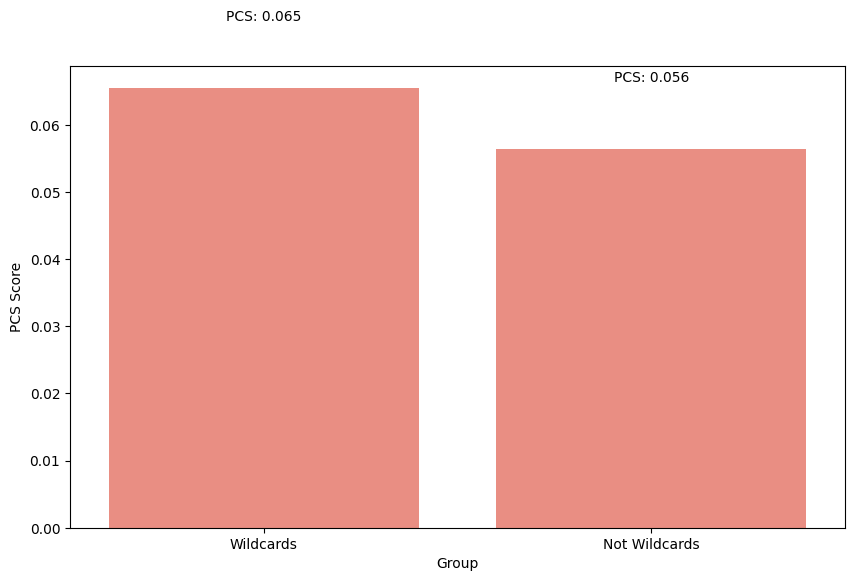

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = {
    'Group': ['Wildcards', 'Not Wildcards'],
    'PCS Score': [wildcard_df['pcs score'].mean(), not_wildcard_df['pcs score'].mean()],
}
plot_df = pd.DataFrame(data)

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot PCS Scores as a bar plot
sns.barplot(x='Group', y='PCS Score', data=plot_df, ax=ax1, color='salmon')

# Set y-axis labels
ax1.set_ylabel('PCS Score')

# Add data point labels
for i, v in enumerate(plot_df['PCS Score']):
    ax1.text(i, v + 0.01, f"PCS: {round(v, 3)}", color='black', ha='center')


plt.show()


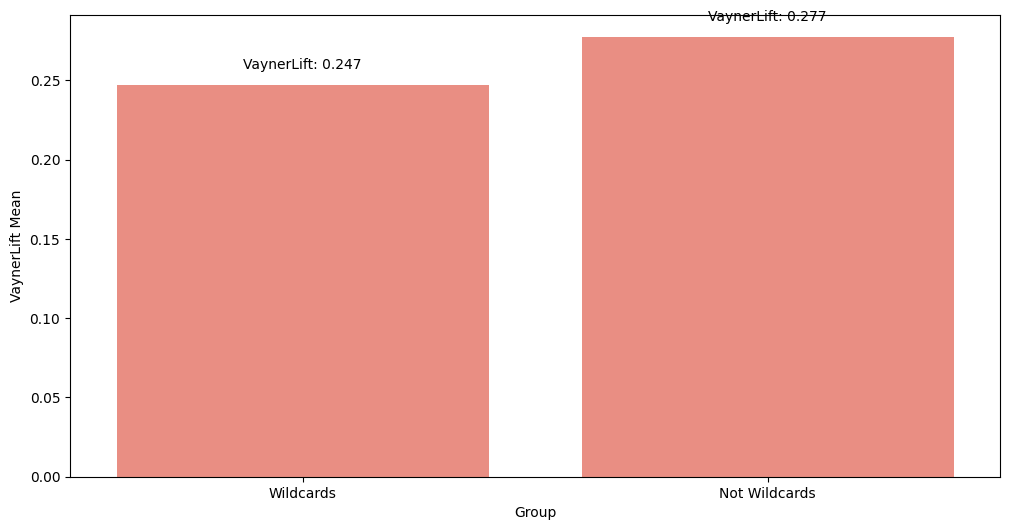

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
data = {
    'Group': ['Wildcards', 'Not Wildcards'],
    'VaynerLift': [wildcard_df['VaynerLift'].mean(), not_wildcard_df['VaynerLift'].mean()],
}
plot_df = pd.DataFrame(data)

# Create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot PCS Scores as a bar plot
sns.barplot(x='Group', y='VaynerLift', data=plot_df, ax=ax1, color='salmon')

# Set y-axis labels
ax1.set_ylabel('VaynerLift Mean')

# Add data point labels
for i, v in enumerate(plot_df['VaynerLift']):
    ax1.text(i, v + 0.01, f"VaynerLift: {round(v, 3)}", color='black', ha='center')


plt.show()


In [29]:
df.shape

(10859, 26)

Frequency of each Word Count group:
1      293
2     2061
3      983
4     1434
5      894
6      547
7      382
8      479
9      379
10     355
11     209
12     248
13      45
14      57
15      89
16      33
17      17
18      15
20      40
25       1
Name: Word Count, dtype: int64


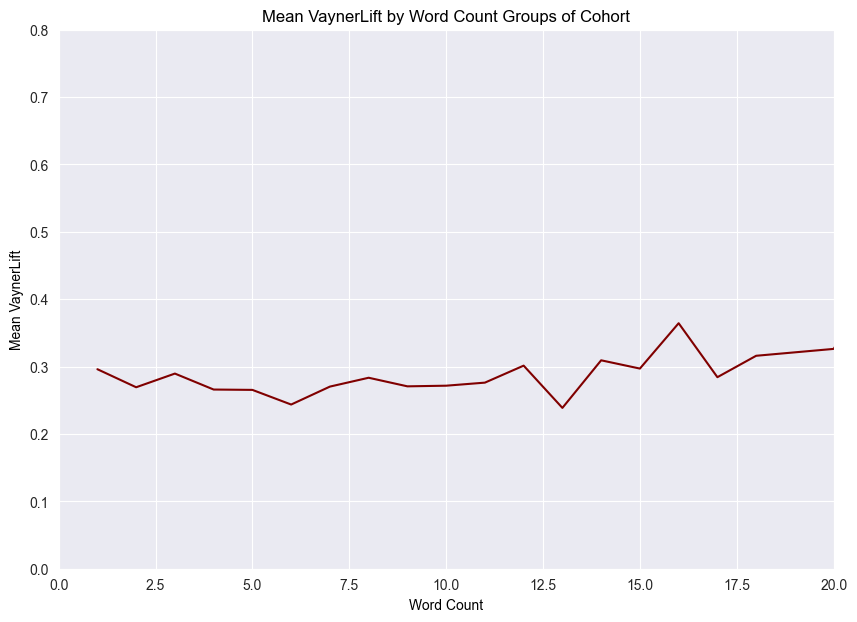

In [30]:
# 2. word count of creative and mean vayner lift - this includes wildcards/ no cohorts

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 1: Calculate word count for each 'Cohort'
df = df[df['CohortCat'] != 'no cohort']
df['Word Count'] = df['Cohort'].apply(lambda x: len(str(x).split()))

# Step 2: Calculate the mean VaynerLift for each word count
grouped_vaynerlift_means = df.groupby('Word Count')['VaynerLift'].mean()

# Step 3: Calculate the frequency of each word count group
grouped_word_counts = df['Word Count'].value_counts().sort_index()

# Create the plot with increased size
plt.figure(figsize=(10, 7))

# Set background color to gray
sns.set_style("darkgrid")

# Plot data with maroon line
sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title with black color
plt.xlabel('Word Count', color='black')
plt.ylabel('Mean VaynerLift', color='black')
plt.title('Mean VaynerLift by Word Count Groups of Cohort', color='black')
plt.xlim(0,20)
plt.ylim(0,0.80)

#for x, y in zip(grouped_vaynerlift_means.index, grouped_vaynerlift_means.values):
   # plt.text(x, y + 0.025, str(grouped_word_counts[x]), color='black')

# Print the frequency of each word count group
print("Frequency of each Word Count group:")
print(grouped_word_counts)

# Show the plot
plt.show()


In [31]:
grouped_vaynerlift_means

Word Count
1     0.296109
2     0.269338
3     0.289640
4     0.265943
5     0.265427
6     0.243685
7     0.270308
8     0.283449
9     0.270705
10    0.271650
11    0.276198
12    0.301426
13    0.238702
14    0.309335
15    0.297069
16    0.364390
17    0.284283
18    0.316062
20    0.326268
25    0.778431
Name: VaynerLift, dtype: float64

In [32]:
# Outlier with one data point and highest Vayner lift (not plotted on the graph)
word_count_25_df = df[df['Word Count'] == 25]['Cohort'].unique()
print(word_count_25_df)

['New Military Parents of Virginia Who Want to Spend As Much Time with Their Child As Possible During K-12 to Make Up For Complex Schedule']


In [33]:
df.head()

,Cohort,CohortCat,Creative,Client,Day On,Platform,Post Date,Post ID,Comments,Comments - Max,...,Nr. of Creatives - Post Date,Nr. of Creatives MAX,Reactions,Replies,Retweets,Saves,Shares,V Lift - Max,VaynerLift,Word Count
0,30-SOMETHING LEBRON FANS SAVORING HIS FINAL SE...,cohort,Better 2 Way Player,Fanatics,14,Facebook,4/28/2023,10159842797542104,22.0,22.0,...,3,3,63.0,0.0,0.0,0.0,2.0,0.257534,0.257534,7
1,Keeping Up with the Car Joneses,cohort,Happy New Year Car Owners,EchoPark,14,Instagram,1/9/2023,CnNePeHPUtJ,0.0,0.0,...,2,2,8.0,0.0,0.0,0.0,0.0,0.040221,0.040221,6
2,PREPAREDNESS IS MY TOP PRIORITY,cohort,Best Road Trip Snack,EchoPark,14,Facebook,4/19/2023,9136641689740813,0.0,0.0,...,2,2,3.0,0.0,0.0,0.0,1.0,0.458971,0.458971,5
4,Inexperienced Enthusiasts,cohort,Ask An Experience Guide,EchoPark,14,Instagram,12/30/2022,CmzEnk0MROq,0.0,0.0,...,1,1,3.0,0.0,0.0,0.0,0.0,0.035878,0.035878,2
6,The Introvert,cohort,It's Not Just a Car,EchoPark,14,Instagram,1/3/2023,Cm9gM9dPl8T,2.0,2.0,...,3,3,5.0,0.0,0.0,0.0,0.0,0.349691,0.349691,2


In [34]:
# 3. frequent keywords and vayner lift mean

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string
from collections import Counter
from nltk.corpus import stopwords

# Filtering out all the wildcard rows
conditions = [
    df['Cohort'] == 'Wildcard',
    df['Cohort'].str.contains('Wildcard Holiday', case=False, na=False),
    df['Cohort'].str.contains('SCOTT - Wildcard', case=False, na=False),
    df['Cohort'].str.contains('UBK - Wildcard', case=False, na=False),
    df['Cohort'].str.contains('Wild card', case=False, na=False),
    df['Cohort'].str.contains('None', case=False, na=False)
]

combined_condition = np.logical_or.reduce(conditions)

keyword_df = df[~combined_condition]

# Adding 'their' and 'THEIR' to the stop words set
stop_words = set(stopwords.words('english'))
stop_words.update(['Their', 'THEIR'])



In [35]:
keyword_df.head()

,Cohort,CohortCat,Creative,Client,Day On,Platform,Post Date,Post ID,Comments,Comments - Max,...,Nr. of Creatives - Post Date,Nr. of Creatives MAX,Reactions,Replies,Retweets,Saves,Shares,V Lift - Max,VaynerLift,Word Count
0,30-SOMETHING LEBRON FANS SAVORING HIS FINAL SE...,cohort,Better 2 Way Player,Fanatics,14,Facebook,4/28/2023,10159842797542104,22.0,22.0,...,3,3,63.0,0.0,0.0,0.0,2.0,0.257534,0.257534,7
1,Keeping Up with the Car Joneses,cohort,Happy New Year Car Owners,EchoPark,14,Instagram,1/9/2023,CnNePeHPUtJ,0.0,0.0,...,2,2,8.0,0.0,0.0,0.0,0.0,0.040221,0.040221,6
2,PREPAREDNESS IS MY TOP PRIORITY,cohort,Best Road Trip Snack,EchoPark,14,Facebook,4/19/2023,9136641689740813,0.0,0.0,...,2,2,3.0,0.0,0.0,0.0,1.0,0.458971,0.458971,5
4,Inexperienced Enthusiasts,cohort,Ask An Experience Guide,EchoPark,14,Instagram,12/30/2022,CmzEnk0MROq,0.0,0.0,...,1,1,3.0,0.0,0.0,0.0,0.0,0.035878,0.035878,2
6,The Introvert,cohort,It's Not Just a Car,EchoPark,14,Instagram,1/3/2023,Cm9gM9dPl8T,2.0,2.0,...,3,3,5.0,0.0,0.0,0.0,0.0,0.349691,0.349691,2


<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:8: DeprecationWarning: invalid escape sequence '\d'
<>:5: DeprecationWarning: invalid escape sequence '\w'
<>:8: DeprecationWarning: invalid escape sequence '\d'
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/1944222392.py:5: DeprecationWarning: invalid escape sequence '\w'
  keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('[^\w\s]', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/1944222392.py:8: DeprecationWarning: invalid escape sequence '\d'
  keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('\d+', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/1944222392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

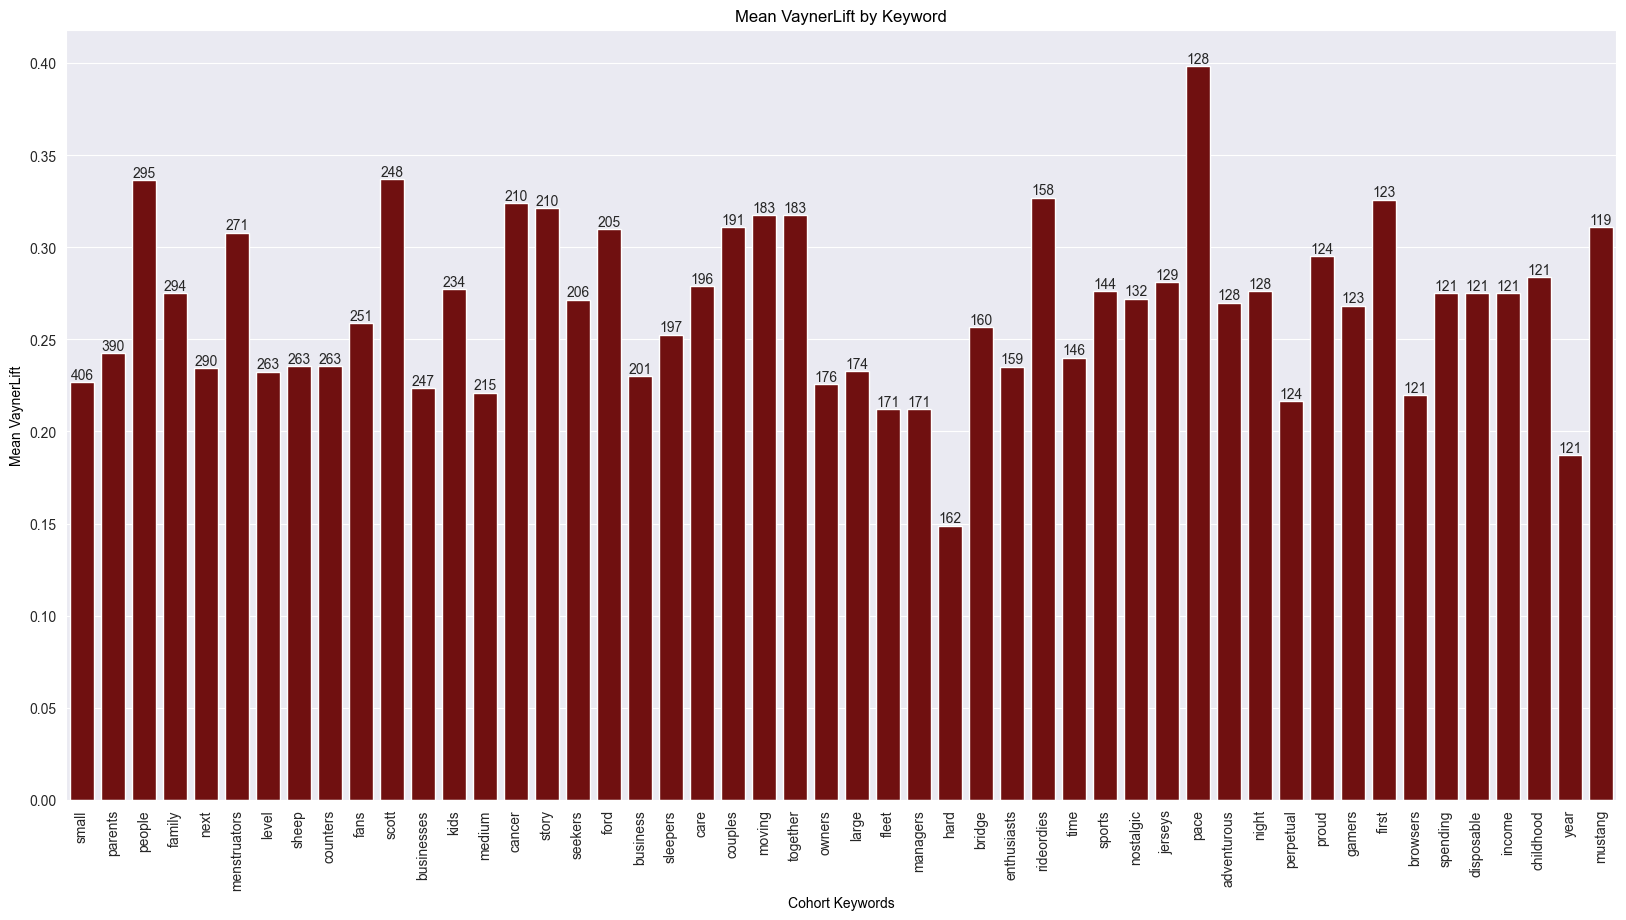

In [36]:
# Convert to lowercase first
keyword_df['Cleaned Cohort'] = keyword_df['Cohort'].str.lower()

# Remove punctuation
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('[^\w\s]', '') 

# Remove numbers
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].str.replace('\d+', '')  

# Define stop words 
stop_words = set(stopwords.words('english'))

# Remove stop words
keyword_df['Cleaned Cohort'] = keyword_df['Cleaned Cohort'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop_words))


# Tokenize the cleaned text and count the frequency of each word
words = keyword_df['Cleaned Cohort'].str.split(expand=True).stack()
word_counts = Counter(words)

# Filter out words that are less than 4 letters long
filtered_word_counts = {word: count for word, count in word_counts.items() if word not in stop_words and len(word) >= 4}

# Get the top 100 most frequent words
top_100_words = dict(sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:50])

# Step 2: For each keyword, find the rows in which the 'Cleaned Cohort' contains this keyword and calculate the mean VaynerLift score
keyword_vaynerlift_means = []
for word in top_100_words.keys():
    vaynerlift_mean = keyword_df[keyword_df['Cleaned Cohort'].str.contains(word, case=False, na=False)]['VaynerLift'].mean()
    keyword_vaynerlift_means.append(vaynerlift_mean)
    

# Create the plot with increased size
plt.figure(figsize=(20, 10))

# Set background color to gray
sns.set_style("darkgrid")

# Create bar plot
barplot = sns.barplot(x=list(top_100_words.keys()), y=keyword_vaynerlift_means, color='maroon')

# Add labels and title with black color
plt.xlabel('Cohort Keywords', color='black')
plt.ylabel('Mean VaynerLift', color='black')
plt.title('Mean VaynerLift by Keyword', color='black')

# Rotate x-axis labels 45 degrees
plt.xticks(rotation=90)

# Add frequency count labels to each bar
for i, word in enumerate(top_100_words.keys()):
    plt.text(i, keyword_vaynerlift_means[i], top_100_words[word], ha='center', va='bottom')

# Show the plot
plt.show()


<>:20: DeprecationWarning: invalid escape sequence '\w'
<>:23: DeprecationWarning: invalid escape sequence '\d'
<>:20: DeprecationWarning: invalid escape sequence '\w'
<>:23: DeprecationWarning: invalid escape sequence '\d'
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/2504593288.py:20: DeprecationWarning: invalid escape sequence '\w'
  filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('[^\w\s]', '')
/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/2504593288.py:23: DeprecationWarning: invalid escape sequence '\d'
  filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('\d+', '')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/trishitasingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trishitasingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/9s/38yb0xn536968pgvsk_rgxj400

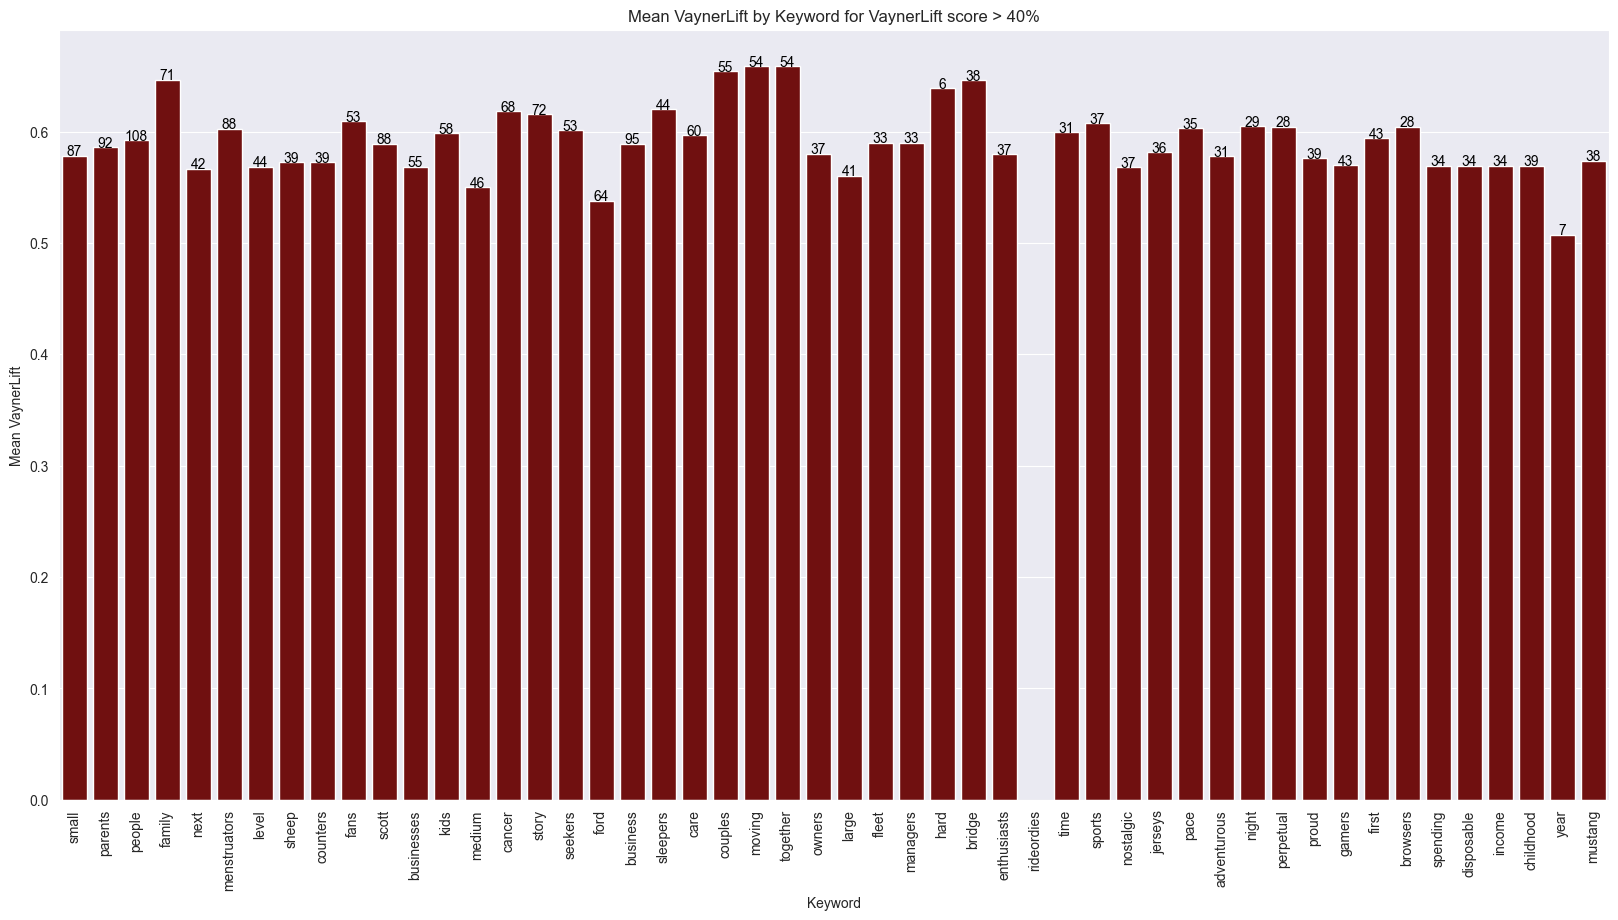

In [37]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')

# Filter the DataFrame to include only rows with a VaynerLift score above 40%
filtered_df = keyword_df[keyword_df['VaynerLift'] > 0.4]

# Convert to lowercase first
filtered_df['Cleaned Cohort'] = filtered_df['Cohort'].str.lower()

# Remove punctuation
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('[^\w\s]', '') 

# Remove numbers
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].str.replace('\d+', '')  

# Define stop words 
stop_words = set(stopwords.words('english'))

# Remove stop words
filtered_df['Cleaned Cohort'] = filtered_df['Cleaned Cohort'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop_words))


# Remove stopwords and words less than 4 letters long
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words and len(word) >= 4]

# Count the frequency of each word
word_freq = Counter(words)

# Get the top 100 most common words
top_100_words = word_freq.most_common(50)

# Calculate the mean VaynerLift score associated with each word
word_vaynerlift_means = {}
word_counts = {}
for word, _ in top_100_words:
    word_rows = filtered_df[filtered_df['Cohort'].str.contains(word, na=False, case=False)]
    word_vaynerlift_means[word] = word_rows['VaynerLift'].mean()
    word_counts[word] = len(word_rows)

# Create the bar plot
plt.figure(figsize=(20, 10))

# Plot data
sns.barplot(x=list(word_vaynerlift_means.keys()), y=list(word_vaynerlift_means.values()), color='maroon')

# Add labels and title
plt.xlabel('Keyword')
plt.ylabel('Mean VaynerLift')
plt.title('Mean VaynerLift by Keyword for VaynerLift score > 40%')

# Add data point labels
for i, word in enumerate(word_vaynerlift_means.keys()):
    plt.text(i, word_vaynerlift_means[word], f"{word_counts[word]}", color='black', ha='center')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [38]:
# Calculate the total number of rows in keyword_df - excluding the wildcard rows/ no-cohort/ special cases
total_rows = len(keyword_df)

# Calculate the number of unique values in the 'Cohort' column
unique_cohorts = keyword_df['Cohort'].nunique()

# Divide total number of rows by the number of unique values
result = total_rows / unique_cohorts
print(result)


17.276985743380855


In [39]:
keyword_df.head()

,Cohort,CohortCat,Creative,Client,Day On,Platform,Post Date,Post ID,Comments,Comments - Max,...,Nr. of Creatives MAX,Reactions,Replies,Retweets,Saves,Shares,V Lift - Max,VaynerLift,Word Count,Cleaned Cohort
0,30-SOMETHING LEBRON FANS SAVORING HIS FINAL SE...,cohort,Better 2 Way Player,Fanatics,14,Facebook,4/28/2023,10159842797542104,22.0,22.0,...,3,63.0,0.0,0.0,0.0,2.0,0.257534,0.257534,7,something lebron fans savoring final seasons
1,Keeping Up with the Car Joneses,cohort,Happy New Year Car Owners,EchoPark,14,Instagram,1/9/2023,CnNePeHPUtJ,0.0,0.0,...,2,8.0,0.0,0.0,0.0,0.0,0.040221,0.040221,6,keeping car joneses
2,PREPAREDNESS IS MY TOP PRIORITY,cohort,Best Road Trip Snack,EchoPark,14,Facebook,4/19/2023,9136641689740813,0.0,0.0,...,2,3.0,0.0,0.0,0.0,1.0,0.458971,0.458971,5,preparedness top priority
4,Inexperienced Enthusiasts,cohort,Ask An Experience Guide,EchoPark,14,Instagram,12/30/2022,CmzEnk0MROq,0.0,0.0,...,1,3.0,0.0,0.0,0.0,0.0,0.035878,0.035878,2,inexperienced enthusiasts
6,The Introvert,cohort,It's Not Just a Car,EchoPark,14,Instagram,1/3/2023,Cm9gM9dPl8T,2.0,2.0,...,3,5.0,0.0,0.0,0.0,0.0,0.349691,0.349691,2,introvert


0: Fanatics
1: EchoPark
2: Ford
3: Casper
4: Wegmans
5: Durex
6: Pico
7: Kimberly Clark
8: Wander Wheels
9: Diageo
10: Zappos
11: Coach
12: St Jude
13: Bose
14: Pearson
15: Ford Pro
16: NatWest


/var/folders/9s/38yb0xn536968pgvsk_rgxj40000gp/T/ipykernel_66855/2296667282.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  client_df = client_df[not_wildcard_df['CohortCat'] != 'no cohort']


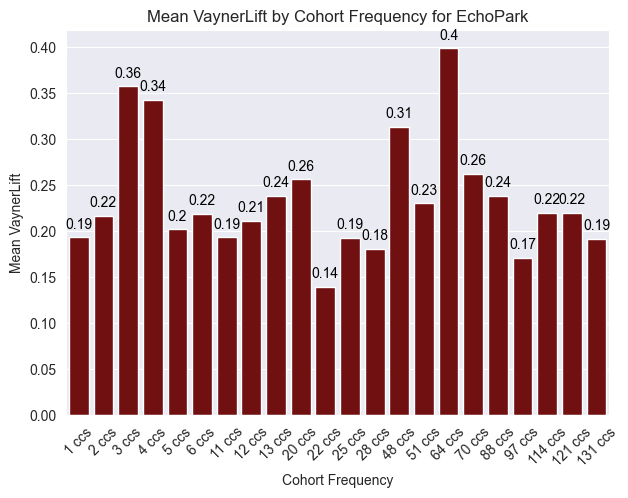

In [40]:
# 5. cohorts frequency and mean vayner lift
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Get the unique clients
unique_clients = not_wildcard_df['Client'].unique()

# Print out the unique clients with their corresponding index
for i, client in enumerate(unique_clients):
    print(f"{i}: {client}")

# Ask for a numeric input
client_index = int(input("Enter the number corresponding to the client: "))

# Get the client corresponding to the input index
client = unique_clients[client_index]

# Subset the DataFrame to include only rows for this client
client_df = not_wildcard_df[not_wildcard_df['Client'] == client]
client_df = client_df[not_wildcard_df['CohortCat'] != 'no cohort']

# Count the frequency of each cohort and create a new column 'Cohort Frequency'
client_df['Cohort Frequency'] = client_df.groupby('Cohort')['Cohort'].transform('count')

# Group by 'Cohort Frequency' and calculate the mean VaynerLift for each group
grouped_vaynerlift_means = client_df.groupby('Cohort Frequency')['VaynerLift'].mean()

# Create the bar plot
plt.figure(figsize=(7, 5))

# Create labels for x-axis
x_labels = [str(i) + ' ccs' for i in grouped_vaynerlift_means.index]

sns.barplot(x=x_labels, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title
plt.xlabel('Cohort Frequency')
plt.ylabel('Mean VaynerLift')
plt.title(f'Mean VaynerLift by Cohort Frequency for {client}')

# Add data point labels
for i, v in enumerate(grouped_vaynerlift_means.values):
    plt.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center')

plt.xticks(rotation=45)

# Show the plot
plt.show()


In [45]:
# Outlier with one data point and highest Vayner lift (not plotted on the graph)
cohorts_20 = client_df[client_df['Cohort Frequency'] >= 130]['Cohort'].unique()
print(cohorts_20)

['New Car New Me']


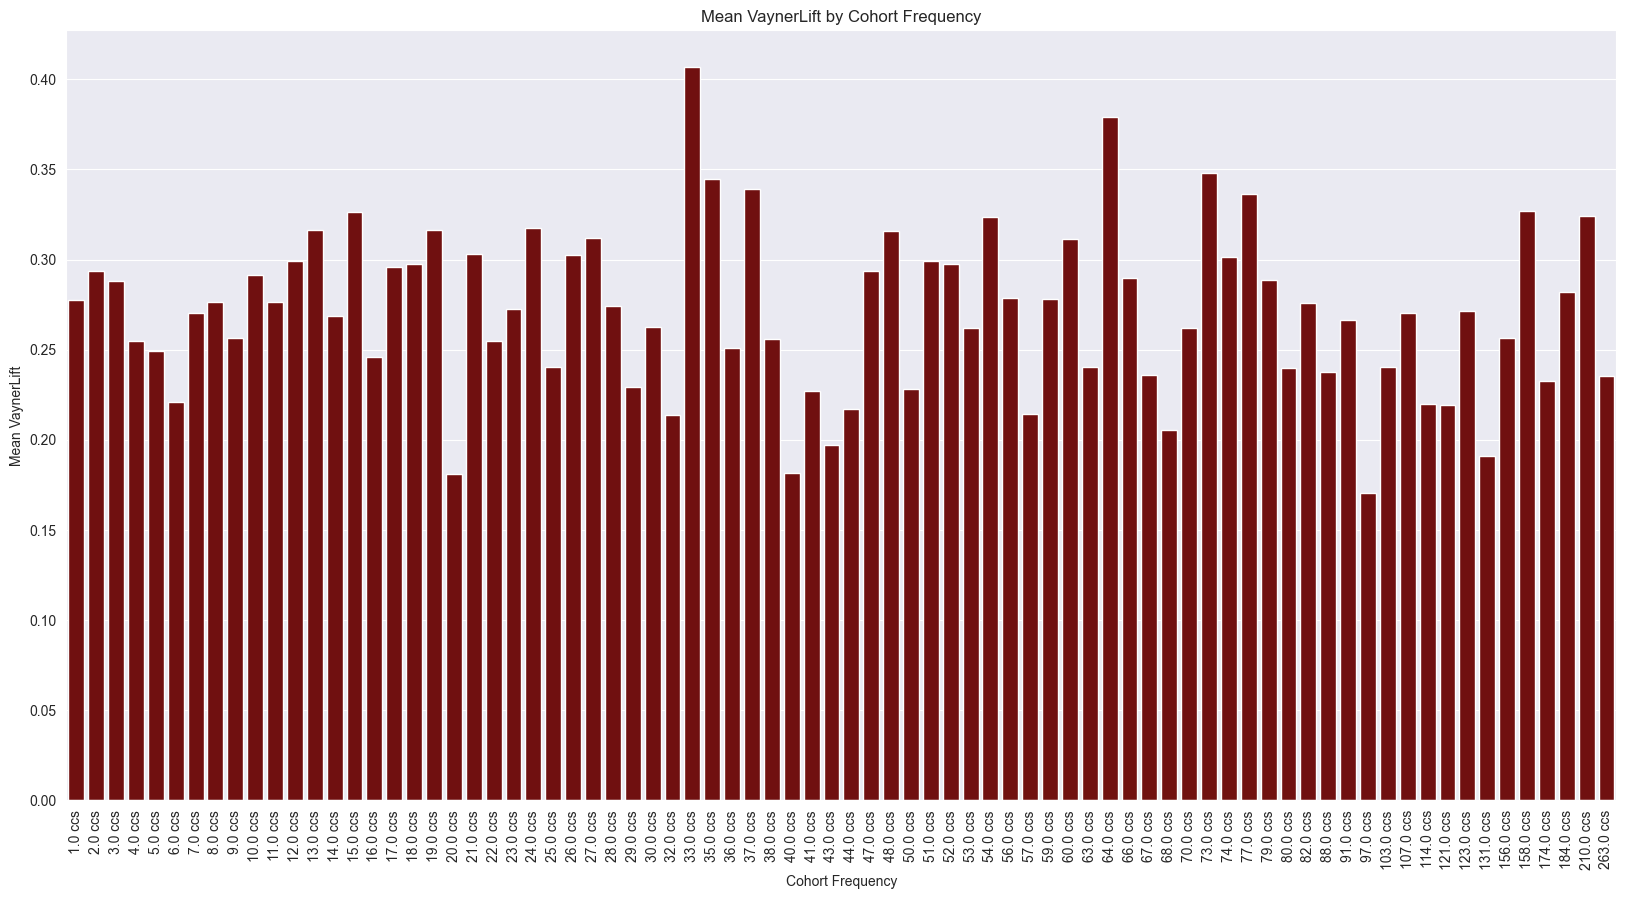

In [46]:
# Cohort frequency vs. VaynerLift for all clients

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Count the frequency of each cohort and create a new column 'Cohort Frequency'
not_wildcard_df['Cohort Frequency'] =  not_wildcard_df.groupby('Cohort')['Cohort'].transform('count')
cohort_df = not_wildcard_df[not_wildcard_df['CohortCat'] != 'no cohort']

# Group by 'Cohort Frequency' and calculate the mean VaynerLift for each group
grouped_vaynerlift_means = cohort_df.groupby('Cohort Frequency')['VaynerLift'].mean()

# Create the bar plot
plt.figure(figsize=(20, 10))

# Create labels for x-axis
x_labels = [str(i) + ' ccs' for i in grouped_vaynerlift_means.index]

sns.barplot(x=x_labels, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title
plt.xlabel('Cohort Frequency')
plt.ylabel('Mean VaynerLift')
plt.title('Mean VaynerLift by Cohort Frequency')

# Add data point labels
#for i, v in enumerate(grouped_vaynerlift_means.values):
#   plt.text(i, v + 0.01, str(round(v, 2)), color='black', ha='center')
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [47]:
# Filter cohorts with frequency > 200
high_frequency_cohorts = cohort_df[cohort_df['Cohort Frequency'] > 200]

# Print unique cohorts from the filtered dataframe
print(high_frequency_cohorts['Cohort'].unique())


['Next Level Sheep Counters' 'People with a Cancer Story']


In [48]:
df.columns

Index(['Cohort', 'CohortCat', 'Creative', 'Client', 'Day On', 'Platform',
       'Post Date', 'Post ID', 'Comments', 'Comments - Max', 'Engagement Rate',
       'Engagements - Max', 'Impressions', 'Impressions - Max',
       'Latest MER - Step 2', 'Max of MER - Step 3',
       'Most Recent MER Date - Step 1', 'Nr. of Creatives - Post Date',
       'Nr. of Creatives MAX', 'Reactions', 'Replies', 'Retweets', 'Saves',
       'Shares', 'V Lift - Max', 'VaynerLift', 'Word Count'],
      dtype='object')

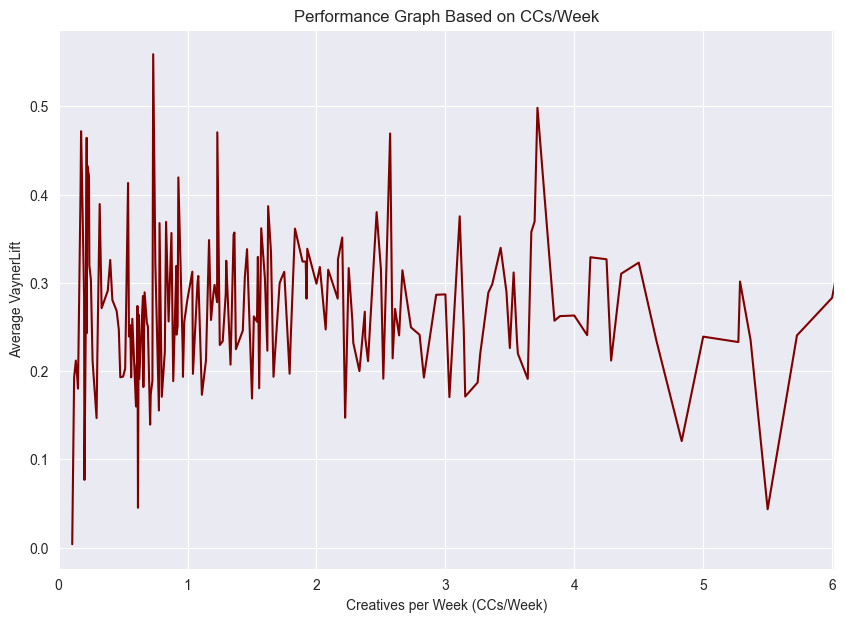

In [70]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming not_wildcard_df is already loaded
# Convert 'Post Date' column to datetime
not_wildcard_df['Post Date'] = pd.to_datetime(not_wildcard_df['Post Date'])
# Sort the DataFrame by 'Post Date'
not_wildcard_df = not_wildcard_df.sort_values(by='Post Date')

# Remove rows where 'Cohort' is 'None'
not_wildcard_df = not_wildcard_df.loc[not_wildcard_df['CohortCat'] != 'no cohort']

# Determine the start date for each cohort
start_dates = not_wildcard_df.groupby('Cohort')['Post Date'].min()

# Calculate the number of weeks since the first post for each cohort
weeks_since_start = ((not_wildcard_df['Post Date'] - not_wildcard_df['Cohort'].map(start_dates)) / timedelta(days=7))
weeks_since_start = weeks_since_start.fillna(0).replace([float('inf'), float('-inf')], 0).astype(int) + 1
not_wildcard_df['Weeks Since Start'] = weeks_since_start

# Calculate average creatives per week for each cohort
ccs_per_week = not_wildcard_df.groupby('Cohort').size() / not_wildcard_df.groupby('Cohort')['Weeks Since Start'].max()
not_wildcard_df['CCs/Week'] = not_wildcard_df['Cohort'].map(ccs_per_week)

# Calculate the mean VaynerLift for each 'CCs/Week' bin
grouped_vaynerlift_means = not_wildcard_df.groupby('CCs/Week')['VaynerLift'].mean()

# Create the performance graph
plt.figure(figsize=(10, 7))
plt.xlim(0, 6.012)
         
# Plot data
sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

# Add labels and title
plt.xlabel('Creatives per Week (CCs/Week)')
plt.ylabel('Average VaynerLift')
plt.title('Performance Graph Based on CCs/Week')

plt.show()


In [71]:
# Get the unique bin values (CCs/Week) 
unique_bins = not_wildcard_df['CCs/Week'].unique()
rounded_bins = [round(bin_value, 2) for bin_value in unique_bins]
rounded_bins_sorted = sorted(rounded_bins)
rounded_bins_sorted


[0.11,
 0.12,
 0.13,
 0.15,
 0.15,
 0.17,
 0.17,
 0.18,
 0.2,
 0.2,
 0.21,
 0.22,
 0.22,
 0.22,
 0.24,
 0.24,
 0.25,
 0.26,
 0.29,
 0.3,
 0.32,
 0.33,
 0.38,
 0.4,
 0.42,
 0.45,
 0.47,
 0.48,
 0.5,
 0.52,
 0.54,
 0.55,
 0.56,
 0.56,
 0.57,
 0.6,
 0.6,
 0.61,
 0.61,
 0.62,
 0.62,
 0.62,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.71,
 0.71,
 0.73,
 0.73,
 0.75,
 0.78,
 0.78,
 0.8,
 0.82,
 0.83,
 0.85,
 0.88,
 0.88,
 0.89,
 0.91,
 0.91,
 0.92,
 0.93,
 0.96,
 0.96,
 0.97,
 1.0,
 1.04,
 1.04,
 1.08,
 1.08,
 1.11,
 1.14,
 1.17,
 1.18,
 1.2,
 1.21,
 1.23,
 1.23,
 1.25,
 1.27,
 1.3,
 1.3,
 1.33,
 1.36,
 1.36,
 1.37,
 1.38,
 1.43,
 1.44,
 1.46,
 1.5,
 1.51,
 1.54,
 1.55,
 1.56,
 1.57,
 1.6,
 1.62,
 1.62,
 1.62,
 1.65,
 1.67,
 1.71,
 1.73,
 1.75,
 1.79,
 1.8,
 1.83,
 1.86,
 1.89,
 1.92,
 1.92,
 1.93,
 2.0,
 2.03,
 2.07,
 2.09,
 2.16,
 2.17,
 2.2,
 2.22,
 2.23,
 2.25,
 2.28,
 2.29,
 2.33,
 2.38,
 2.38,
 2.4,
 2.47,
 2.5,
 2.52,
 2.57,
 2.59,
 2.61,
 2.64,
 2.67,
 2.73,
 2.8,
 2.83,
 2.93,
 3.0,
 3.03,

In [73]:
high_ccs_cohorts = not_wildcard_df[not_wildcard_df['CCs/Week'] > 10]

# Display these cohorts
print(high_ccs_cohorts[['Cohort', 'CCs/Week']].drop_duplicates())


                                                 Cohort   CCs/Week
9562                                         All Trucks  13.166667
9430                                  Ford Ride-Or-Dies  10.533333
1500  MODERN SUBURBAN GOLFERS ENDING THEIR HIBERNATI...  11.500000
1642                                             launch  20.000000


In [74]:
high_ccs_cohorts = df[df['CCs/Week'] > 5]

# Display these cohorts
print(high_ccs_cohorts[['Cohort', 'CCs/Week']].drop_duplicates())


                                                  Cohort   CCs/Week
584                            Next Level Sheep Counters   5.367347
3152                         Leveling Up to Adult Living   5.500000
3557                                     Sleepers Bridge   8.210526
2455   Hot Sleepers Trying to Avoid Their AC At All C...   8.333333
4443                     Small, Medium, Large Businesses   5.272727
2178        Couples (and family) Moving Up & In Together   6.083333
3871                                          All Trucks  13.166667
5663                                  Adventurous Family   6.150000
5504                                              Gamers   9.000000
9430                                   Ford Ride-Or-Dies  10.533333
1707                                 Presidents Day Sale   6.000000
8274   UBK - Menstruators who are proud of their peri...   5.285714
9501                            20s + 30s Main Character   7.000000
9692                                   Pace the 

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_graph_for_client(client_name, dataframe):
    # Filter the dataframe for the specified client
    client_df = dataframe[dataframe['Client'] == client_name]
    
    # Convert 'Post Date' column to datetime (if it's not already)
    if client_df['Post Date'].dtype != 'datetime64[ns]':
        client_df['Post Date'] = pd.to_datetime(client_df['Post Date'])
        
    # Sort the DataFrame by 'Post Date'
    client_df = client_df.sort_values(by='Post Date')

    # Remove rows where 'Cohort' is 'None'
    client_df = client_df.loc[client_df['CohortCat'] != 'no cohort']

    # Calculate the mean VaynerLift for each 'CCs/Week' bin
    grouped_vaynerlift_means = client_df.groupby('CCs/Week')['VaynerLift'].mean()

    # Create the performance graph
    plt.figure(figsize=(10, 7))
    #plt.xlim(0, 6.012)
             
    # Plot data
    sns.lineplot(x=grouped_vaynerlift_means.index, y=grouped_vaynerlift_means.values, color='maroon')

    # Add labels and title
    plt.xlabel('Creatives per Week (CCs/Week)')
    plt.ylabel('Average VaynerLift')
    plt.title(f'Performance Graph for {client_name} Based on CCs/Week')

    plt.show()

# Example usage: plot_graph_for_client('Your Client Name', not_wildcard_df)


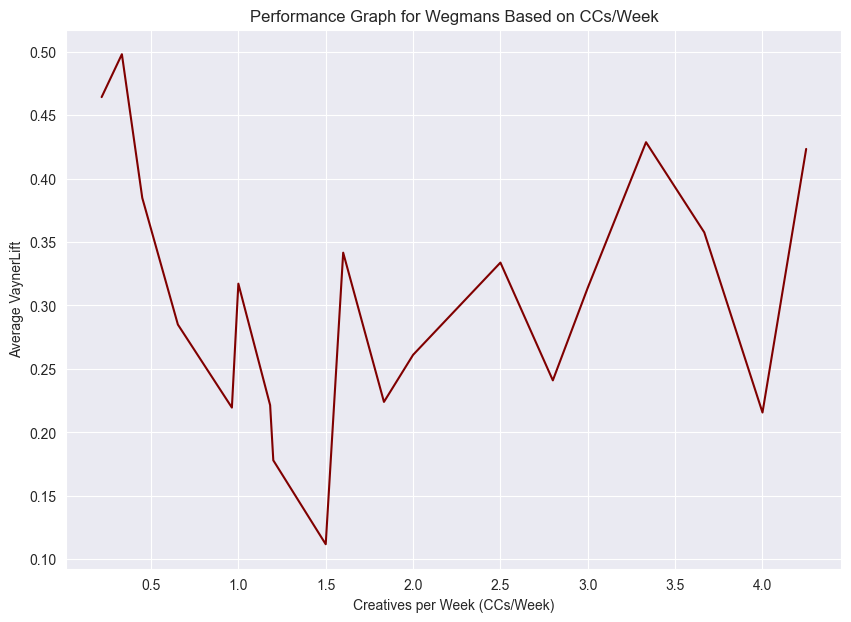

In [86]:
plot_graph_for_client("Wegmans", not_wildcard_df)

In [91]:
not_wildcard_df.to_csv("final_df.csv", index=False)


<h3> Will's approach to CCs/Week Analysis

In [ ]:
from datetime import datetime, timedelta
# Convert 'Post Date' column to datetime
df['Post Date'] = pd.to_datetime(df['Post Date'])
# Sort the DataFrame by 'Post Date'
df = df.sort_values(by='Post Date')

In [ ]:
df = df.loc[df['CohortCat'] != 'no cohort']

# Get the list of unique clients
clients = df['Client'].unique()
print("Available clients:", clients)

# Get the client name as input
client = input("Enter the client name: ")
client = 'Durex'

In [ ]:
# Remove rows where 'Cohort' is 'None'

# Validate the client input
# Filter the DataFrame to include only rows for this client
# filtered_df = df[df['Client'] == client]
filtered_df = df

# Determine the start date for each cohort
start_dates = filtered_df.groupby('Client')['Post Date'].min()


# Calculate the number of creatives made per week
filtered_df['Start Date'] = filtered_df['Client'].map(start_dates)

In [ ]:
import numpy as np
def agg_cc_freq(x):
    d = {}

    x_sorted = x.sort_values(by='Weeks Since Start')

    weeks_between_posts = x_sorted['Weeks Since Start'].diff().dropna()

    d['num_cc'] = x.shape[0]
    d['num_weeks_ran'] = x['Weeks Since Start'].max()
    d['avg_weeks_since_first_cc'] = x['Weeks Since Start'].mean()
    d['median_weeks_since_first_cc'] = x['Weeks Since Start'].median()

    # d['min_weeks_btwn_posts'] = weeks_between_posts.min()
    # d['max_weeks_btwn_posts'] = weeks_between_posts.max()
    d['avg_weeks_btwn_posts'] = weeks_between_posts.mean()
    d['std_weeks_btwn_posts'] = weeks_between_posts.std()
    if d['num_weeks_ran'] > 0:
        d['relative_std_gap'] = round(weeks_between_posts.std() *100/ d['num_weeks_ran'],2)
    else:
        d['relative_std_gap'] = np.nan

    d['avg_vaynerlift'] = x['VaynerLift'].mean()
    d['median_vaynerlift'] = x['VaynerLift'].median()

    return pd.Series(d, list(d.keys()))

grouped_vaynerlift_means = filtered_df.groupby('Client').apply(agg_cc_freq).reset_index()

In [ ]:
grouped_vaynerlift_means

In [ ]:
grouped_vaynerlift_means = grouped_vaynerlift_means[(grouped_vaynerlift_means['num_cc']>4) & (grouped_vaynerlift_means['num_weeks_ran']>4)& (grouped_vaynerlift_means['relative_std_gap']<50)]

In [ ]:
#Plot the average weeks between posts against the average vaynerlifts per post for each cohort
plt.figure
sns.scatterplot(x='avg_weeks_btwn_posts', y='avg_vaynerlift', data=grouped_vaynerlift_means)
plt.xlim(0,1.5)